# Dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import pdfo
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import statsmodels.api as sm
LOWESS = sm.nonparametric.lowess
import eofs
import xrft
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import warnings

import pyarrow as pa
import pyarrow.parquet as pq

from IPython.display import display, clear_output

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from fair import *
plt.style.use('/home/leachl/Documents/Thesis/ancil/figure-style.mplstyle')

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=False,lon=False):
    if not lon is False:
        ax.set_xticks(lon, crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if not lat is False:
        ax.set_yticks(lat, crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Define functions

In [3]:
## function for hacking seaborn's catplot to make it pretty

def hack_catplot_range(x,y,hue,ci=66,dodge=False,hue_order=False,palette=False,**kwargs):
    
    x = x.astype(str)
    
    # calculate desired quantiles
    quantiles = [0.5-ci/200 , 0.5+ci/200]
    
    # calculate x data
    plot_x = dict(zip(x.unique(),np.arange(x.unique().size)))
    
    # if hue order
    if not hue_order:
        hue_order = hue.unique().tolist()
    
    hue_number = len(hue_order)
    
    # if dodge
    if dodge:
        plot_x_dodge = dict(zip(hue_order,np.linspace(-dodge/2,dodge/2,hue_number)))
    else:
        plot_x_dodge = dict(zip(hue.unique(),np.zeros(hue_number)))
    
    # groupby x,hue and plot
    for i,((x_level,hue_level),gr) in enumerate(y.groupby([x,hue])):
        
        if palette:
            kwargs['color'] = palette[hue_order.index(hue_level)]
        
        _y = np.nanquantile(gr.values,quantiles,interpolation='nearest')
        ## replace infs
        _y = np.where(np.isinf(_y),999999,_y)
        
        _x = plot_x[x_level] + plot_x_dodge[hue_level]
        
        plt.vlines(_x,*_y,lw=matplotlib.rcParams['lines.linewidth']*1.8,**kwargs)

In [4]:
palette = get_palette.IBM_color_blind().to_sn_palette()
palette1 = get_palette.color_blind().to_sn_palette()
## textwidth of Thesis
textwidth = 5.848611111111111

# Retrieve data

In [5]:
def preproc_ts(ds):
    
    ds = ds.sel(time=(ds['time.dayofyear'].isin(np.arange(151,241)))&(ds['time.year'].isin(np.arange(1950,2019))))
    
    ds['year'] = ds.time.dt.year
    
    return ds.squeeze().set_coords('year')

EObs = xr.open_mfdataset('/home/leachl/Documents/Attribution/BAMs_2018_Europe_summer/Reanalysis/E_Obs_BI_daily.nc',preprocess=preproc_ts).tg.to_dataframe().set_index('year',append=True).tg
RACMO = xr.open_mfdataset('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/RACMO/TMEAN/BI_ts/MERGED.nc',preprocess=preproc_ts).t2m.to_dataframe().set_index('year',append=True).t2m
CLIM = xr.open_mfdataset('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/soge-home/users/linc3691/HadGEM3A/BI_TMEAN_DAILY/BI_TMEAN_ENS.nc',preprocess=preproc_ts).tas.to_dataframe().set_index('year',append=True).tas

## separate function to preprocess EUROCORDEX
def preproc_ec_ts(ds):
    
    ds = ds.copy()
    record = int(ds.encoding['source'].split('_')[-1].split('.')[0])
    ds = ds.expand_dims({'record':[record]}).rename(tasAdjust='t2m')
    ds = preproc_ts(ds)
    ds = ds.assign_coords(time=pd.to_datetime([x+'-01-01' for x in ds.time.dt.year.values.astype(str)])+pd.to_timedelta(ds.time.dt.dayofyear.values,unit='d'))
    return ds.transpose('time',...)

EC=xr.open_mfdataset('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/EUROCORDEX/TMEAN/BI_ts/tasAdjust_day_eu11bc_rcp45_*.nc',preprocess=preproc_ec_ts,combine='nested',concat_dim=['record']).t2m.to_dataframe().set_index('year',append=True).t2m

In [6]:
def compute_ps(x):
    
    f,Pxx = sp.signal.periodogram(x,fs=1/(3600*24))
    
    return pd.Series(Pxx[1:],index=pd.Index(1/(f[1:]*3600*24),name='period'),name='power')

CLIM_ps = CLIM.groupby(['record','year']).apply(compute_ps).rename('t2m')
EObs_ps = EObs.groupby(['year']).apply(compute_ps).rename('t2m')
EObs_ps = pd.concat([EObs_ps],keys=[0],names=['record'])
RACMO_ps = RACMO.groupby(['record','year']).apply(compute_ps).rename('t2m')
EC_ps = EC.groupby(['record','year']).apply(compute_ps).rename('t2m')

In [7]:
ps_df = pd.concat([EObs_ps.reset_index(),CLIM_ps.reset_index(),RACMO_ps.reset_index(),EC_ps.reset_index()],keys=['E-OBS','HadGEM3-A','RACMO','EURO-CORDEX'],names=['source']).reset_index().drop('level_1',axis=1)

In [8]:
ps_ds = ps_df.set_index(['source','year','period','record']).to_xarray()

In [9]:
ps_rel_df = (ps_ds.t2m/(ps_ds.sel(source='E-OBS',record=0).mean('year').t2m)).to_dataframe().dropna().reset_index()

In [10]:
ps_df = pd.concat([ps_df.sort_values(['source','record','year','period']).reset_index(drop=True),ps_rel_df.sort_values(['source','record','year','period']).t2m.rename('fraction').reset_index(drop=True)],axis=1)

Text(0.5, 1.05, 'Summer PSD')

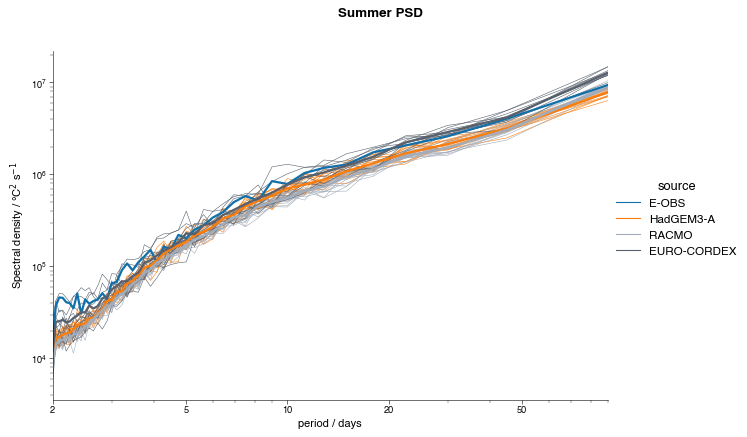

In [11]:
g=sn.relplot(data=ps_df,x='period',y='t2m',hue='source',hue_order=['E-OBS','HadGEM3-A','RACMO','EURO-CORDEX'],palette=palette1[:4],kind='line',ci=None,lw=2,aspect=1.5)

## plot HadGEM ensemble
sn.lineplot(data=ps_df.dropna(),x='period',y='t2m',hue='source',hue_order=['E-OBS','HadGEM3-A','RACMO','EURO-CORDEX'],palette=palette1[:4],ci=None,size='record',legend=False,sizes=(0.5,0.5),zorder=-1)

g.set(xlim=(2,90),xscale='log',yscale='log',ylabel='Spectral density / \N{DEGREE SIGN}C$^2$ s$^{-1}$',xlabel='period / days')

## set x ticks
g.axes[0,0].set_xticks([2,5,10,20,50])
g.axes[0,0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# figure layout
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('Summer PSD',fontweight='bold',y=1.05)

''

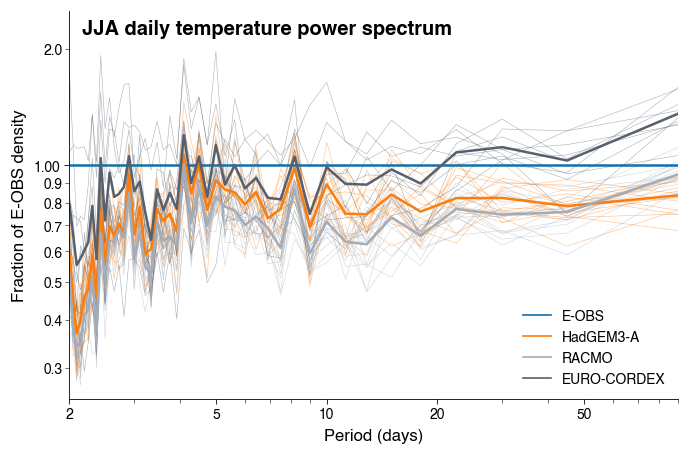

In [12]:
g=sn.relplot(data=ps_df,x='period',y='fraction',hue='source',hue_order=['E-OBS','HadGEM3-A','RACMO','EURO-CORDEX'],palette=palette1[:4],kind='line',ci=None,aspect=1.5,lw=1.5,facet_kws=dict(legend_out=False))

## plot ensembles
sn.lineplot(data=ps_df.dropna(),x='period',y='fraction',hue='source',hue_order=['E-OBS','HadGEM3-A','RACMO','EURO-CORDEX'],palette=palette1[:4],ci=None,size='record',legend=False,sizes=(0.33,0.33),alpha=0.5,zorder=-1)

g.set(xlim=(2,90),xscale='log',yscale='log',ylabel='Fraction of E-OBS density',xlabel='Period (days)', ylim=(0.25,2.5))

## set x ticks
g.axes[0,0].set_xticks([2,5,10,20,50])
g.axes[0,0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

## set y ticks
g.axes[0,0].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
g.axes[0,0].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

## move legend
plt.legend(loc='lower right',fontsize='small')

## add title
g.axes[0,0].text(0.02,0.98,'JJA daily temperature power spectrum',transform=g.axes[0,0].transAxes,va='top',ha='left',fontweight='bold',fontsize='large')

# figure layout
g.fig.dpi=120
fig_aspect = 2/3
g.fig.set_size_inches(textwidth,textwidth*fig_aspect)
g.fig.patch.set_facecolor('xkcd:white')
plt.tight_layout()

## save to Thesis directory
[g.fig.savefig('/home/leachl/Documents/Thesis/Ch1/Figures/Fig1.7.'+x, dpi=600) for x in ['pdf','png']]
''